In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read Data 

In [2]:
#read csv
example_data=pd.read_csv('exampledata/example_data.csv')

In [3]:
#explore data
example_data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,target
0,0.000001,0.402788,0.00,3.0,0.00,1,0.00,2,0
1,-0.016680,0.883240,0.00,7.0,120.00,1,120.00,1,0
2,NaN,1.000000,18590.00,12.0,0.00,2,181110.00,2,0
3,-0.022772,0.845900,6776.38,15.0,11386.22,1,11386.22,1,1
4,-0.017000,0.646375,0.00,7.0,26040.00,2,26180.00,2,0


In [4]:
example_data.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,target
count,675223.000000,682088.000000,6.898500e+05,690777.000000,6.881130e+05,690777.000000,6.907770e+05,690777.000000,690777.000000
mean,-0.047843,0.582920,2.546897e+04,22.397811,6.113807e+04,1.624630,2.432297e+05,2.314123,0.568590
std,5.620416,11.399961,1.038228e+05,24.657208,6.639581e+05,1.172059,1.545585e+06,1.602854,0.495273
min,-3394.157773,0.000000,-4.471140e+06,1.000000,-2.100000e+07,1.000000,0.000000e+00,1.000000,0.000000
25%,-0.030267,0.338315,0.000000e+00,4.000000,0.000000e+00,1.000000,8.490000e+03,1.000000,0.000000
50%,-0.026920,0.519746,4.486410e+03,10.000000,3.684990e+03,1.000000,3.275000e+04,2.000000,1.000000
75%,-0.016941,0.680248,2.048000e+04,37.000000,2.639000e+04,2.000000,9.249000e+04,3.000000,1.000000
max,1181.129066,3532.651466,1.755922e+07,90.000000,5.000000e+07,15.000000,5.000000e+07,16.000000,1.000000


# Train test split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#Валидация
train_data, test_data = train_test_split(example_data,test_size=0.3,stratify=example_data["target"], random_state=42)

In [7]:
print('Target rate: {}, Observations: {}'.format(train_data['target'].mean(), train_data.shape[0]))
print('Target rate: {}, Observations: {}'.format(test_data['target'].mean(), test_data.shape[0]))

Target rate: 0.568590590702378, Observations: 483543
Target rate: 0.5685891311271316, Observations: 207234


# Correlations

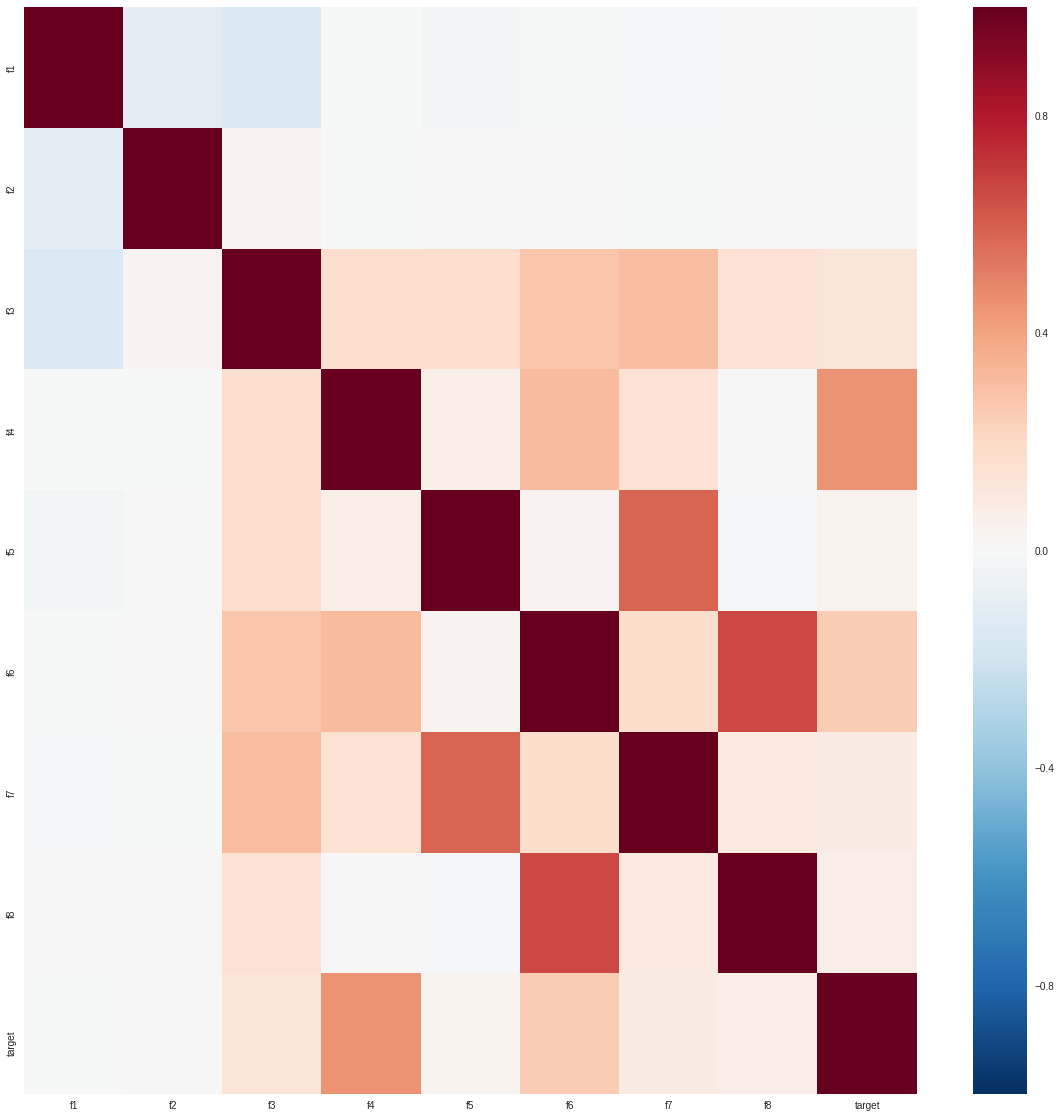

In [8]:
import seaborn as sns
def correlation(dataset, title_text):
    correlations=dataset.corr()
    sns.heatmap(correlations)
    plt.title(title_text)
    plt.show()
    return correlations

plt.figure(figsize=[20,20])
corr=correlation(example_data,'')  

# WoE Binning

In [9]:
import riskpy
from riskpy.modeling.binning import Binner
import riskpy.graphs.graphs as grph

## Find binning

In [10]:
#поиск бинов
binner=Binner()
binner_bins=binner.fit(data=train_data,target='target')

## Plot found binnings

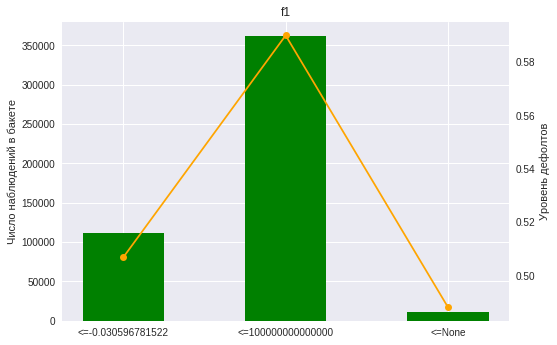

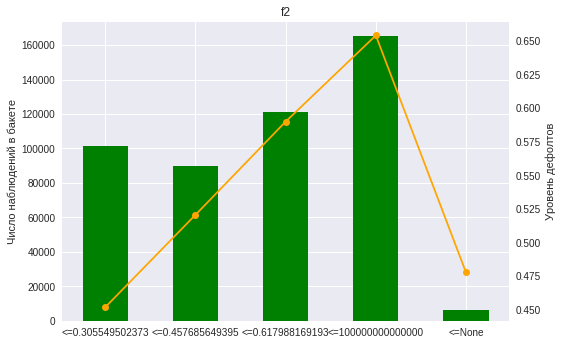

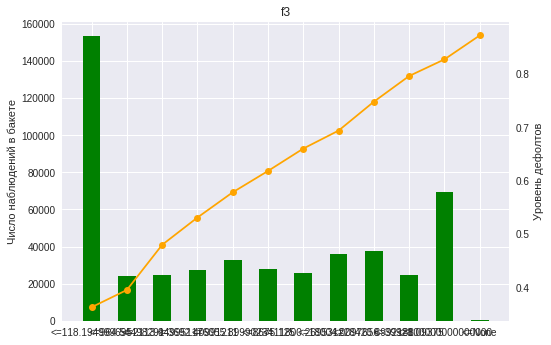

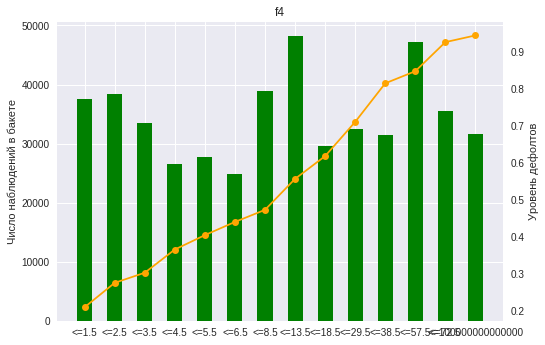

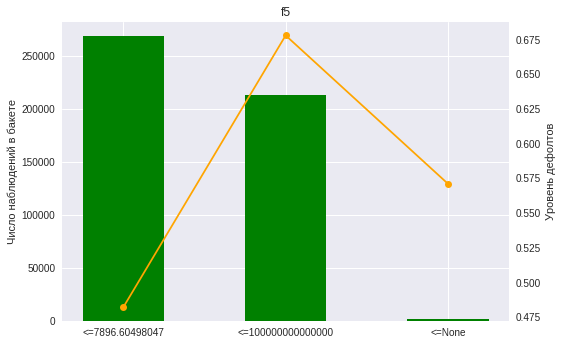

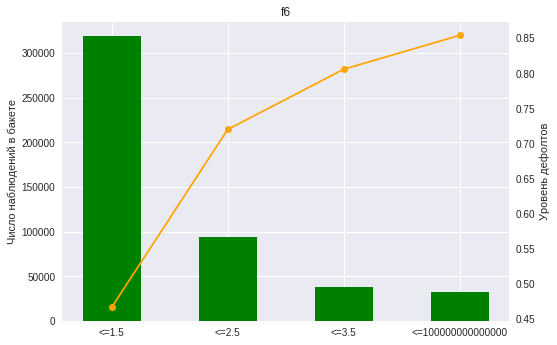

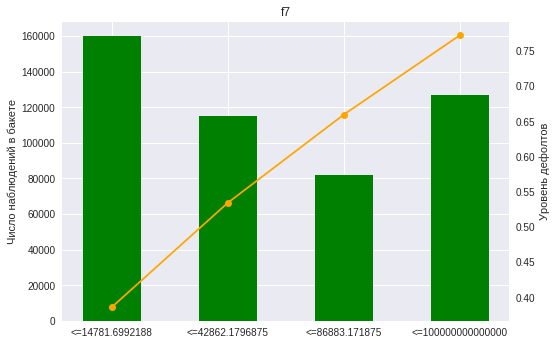

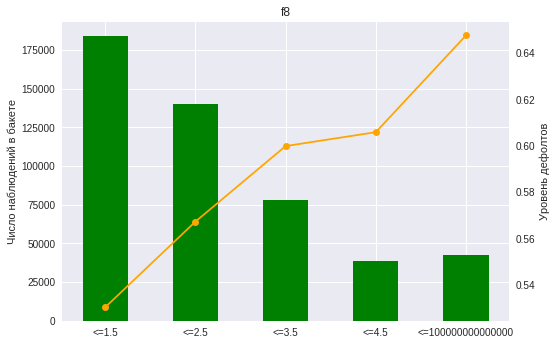

In [11]:
grph.binning_barchart(binner.get_fitted_bins())

## Transform data with found binnings

In [12]:
binned_train=binner.transform(train_data)
binned_test=binner.transform(test_data)

In [13]:
#list of new columns in transformed data
binned_train.columns

Index(['f1_woe', 'f2_woe', 'f3_woe', 'f4_woe', 'f5_woe', 'f6_woe', 'f7_woe',
       'f8_woe', 'target'],
      dtype='object')

## Save binning results

In [14]:
#serialize binner
binner.to_file('exampledata/binner/old_sick_binner.bf')

In [15]:
#binning rules to sql
sql=binner.to_sql()
with open('exampledata/binner/old_sick_binner.txt', 'w') as f:
    f.write(sql)    

In [16]:
#binned data to csv
binned_train.to_csv('exampledata/binned_data/binned_train.csv')
binned_test.to_csv('exampledata/binned_data/binned_test.csv')

## HHI for found bins

In [17]:
bins=binner.get_fitted_bins()

In [18]:
def bining_hhi(b):
    c=b._counts
    tc=[np.sum(t) for t in c]
    tcs=tc/np.sum(tc)
    return np.sum(tcs**2)
    
hh_df=pd.DataFrame([[b_1._name,bining_hhi(b_1)] for b_1 in bins])
hh_df.head()

,0,1
0,f1,0.612597
1,f2,0.257996
2,f3,0.154138
3,f4,0.074176
4,f5,0.502752


# Regression models

In [19]:
from riskpy.modeling.modeler import Modeler

#Create Modeler object
modeler = Modeler(train_dataset=binned_train,test_dataset=binned_test, oot_dataset=None,target='target')

## Onefactor analysis

In [20]:
#xplore factors' gini on train and test (out of time - optionally)
gini_ofi=modeler.ExploreOneFactorImportance(binned_train.drop(['target'], axis=1).columns)

gini_ofi

,TRAIN,TEST
f1_woe,0.065581,0.067141
f2_woe,0.174725,0.174823
f3_woe,0.411212,0.410428
f4_woe,0.565816,0.564660
f5_woe,0.196798,0.197458
f6_woe,0.287634,0.287279
f7_woe,0.347800,0.346842
f8_woe,0.081998,0.082389


In [21]:
binned_train.columns

Index(['f1_woe', 'f2_woe', 'f3_woe', 'f4_woe', 'f5_woe', 'f6_woe', 'f7_woe',
       'f8_woe', 'target'],
      dtype='object')

### Population stability index

In [22]:
from riskpy.utilities.common_metrics import psi
variables_psi = psi(data1=binned_train, data2=binned_test)
variables_psi

[['f1_woe', 8.550727633959571e-06],
 ['f2_woe', 1.67057316357302e-05],
 ['f3_woe', 8.199335257864198e-05],
 ['f4_woe', 0.00010056154718253393],
 ['f5_woe', 1.0732954962733024e-05],
 ['f6_woe', 3.654919051355558e-05],
 ['f7_woe', 2.21707133039504e-05],
 ['f8_woe', 4.206367376294821e-06],
 ['target', 8.684873955637168e-12]]

# Multy factor analysis

In [23]:
#define what columns to use in analysis
columns_in_model = ['f1_woe', 'f2_woe', 'f3_woe', 'f4_woe', 'f5_woe', 'f6_woe', 'f7_woe','f8_woe']

## Stepwise selection

In [24]:
log, models=modeler.StepwiseSelection(columns_in_model)

Optimization terminated successfully.
         Current function value: 0.550996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519903
         Iterations 6


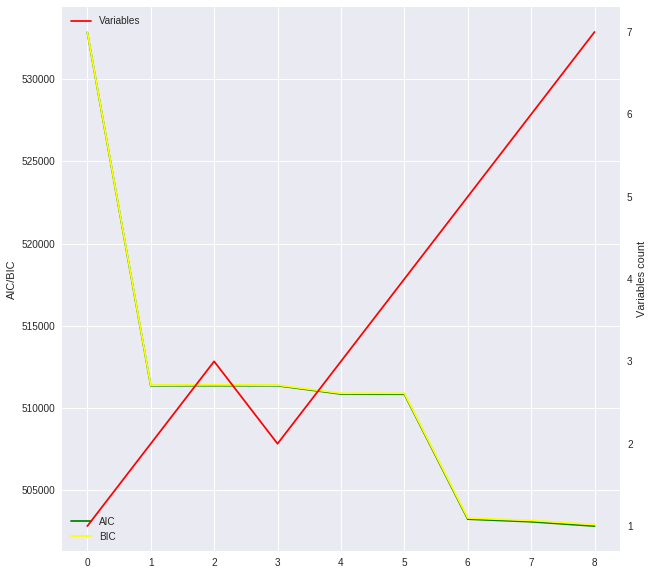

,Added,Removed,Model description,AIC,BIC,Variables count
0,f4_woe added (p-value=0.0),,Logit Regression Re...,532864.741558,532886.919349,1
1,f3_woe added (p-value=0.0),,Logit Regression Re...,511352.544635,511385.811322,2
2,f7_woe added (p-value=0.5183556827600998),,Logit Regression Re...,511354.127382,511398.482964,3
3,,f7_woe removed (p-value:0.5183556827600998),Logit Regression Re...,511352.544635,511385.811322,2
4,f6_woe added (p-value=3.084907567002595e-112),,Logit Regression Re...,510847.004633,510891.360215,3
5,f5_woe added (p-value=3.98446755846689e-05),,Logit Regression Re...,510832.141691,510887.586169,4
6,f2_woe added (p-value=0.0),,Logit Regression Re...,503229.325515,503295.858888,5
7,f8_woe added (p-value=7.563769258573195e-37),,Logit Regression Re...,503070.790752,503148.413021,6
8,f1_woe added (p-value=8.011745069212794e-60),,Logit Regression Re...,502806.654204,502895.365369,7


In [25]:
#stepwise result summary
sw_summary=modeler.StepwiseSummary()
sw_summary

In [26]:
#select best model
best_model_index=np.argmin(sw_summary['AIC'])
best_model_index

8

In [27]:
#columns in best model
columns_in_best_model=list(models[best_model_index].params.index.values[1:])
columns_in_best_model

['f8_woe', 'f6_woe', 'f4_woe', 'f2_woe', 'f5_woe', 'f3_woe', 'f1_woe']

# Final Model

In [28]:
#factors in final model
final_columns_in_model=['f5_woe', 'f4_woe', 'f3_woe', 'f8_woe', 'f2_woe', 'f6_woe', 'f1_woe']

In [29]:
#fit final model
modeler.Fit(final_columns_in_model)

Optimization terminated successfully.
         Current function value: 0.519903
         Iterations 6


(502806.65420433314, 502895.36536853132)

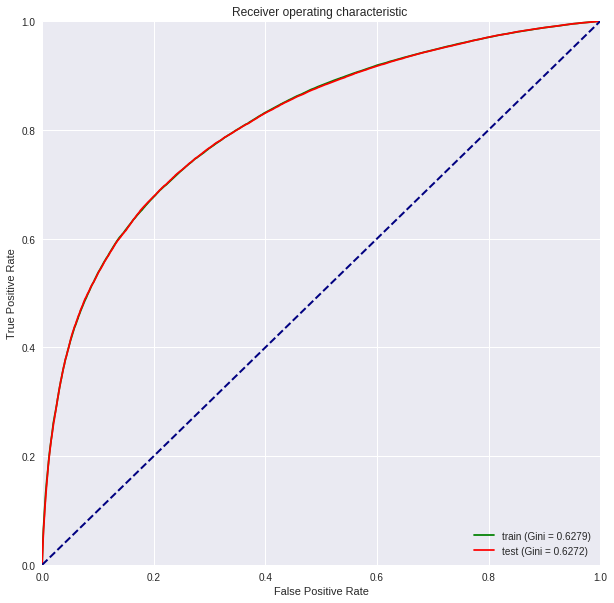

In [30]:
#evaluate final model
modeler.GetModelQuality()

In [31]:
#final model summary
modeler.GetModelSummary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               483543
Model:                          Logit   Df Residuals:                   483535
Method:                           MLE   Df Model:                            7
Date:                Wed, 12 Sep 2018   Pseudo R-squ.:                  0.2396
Time:                        14:20:02   Log-Likelihood:            -2.5140e+05
converged:                       True   LL-Null:                   -3.3060e+05
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2802      0.003     80.075      0.000       0.273       0.287
f5_woe        -0.1094      0.009    -11.560      0.000      -0.128      -0.091
f4_woe        -0.9044      0.004   -239.496      0.000      -0.912      -0.897
f3_woe        -0.4675      0.006    -84.027      0.000      -0.478      -0.457
f8_woe        -0.3874      0.030    -13.126      0.000      -0.445      -0.330
f2_woe        -0.9387      0.012    -78.697      0.000      -0.962      -0.915
f6_woe        -0.1297      0.008    -15.976      0.000      -0.146      -0.114
f1_woe        -0.3926      0.024    -16.313      0.000      -0.440      -0.345
==============================================================================
"""

In [32]:
# final model factors' VIF
modeler.VIF()

,VIF
f5_woe,1.262619
f4_woe,1.432135
f3_woe,1.766442
f8_woe,1.871005
f2_woe,1.210072
f6_woe,2.543866
f1_woe,1.099291


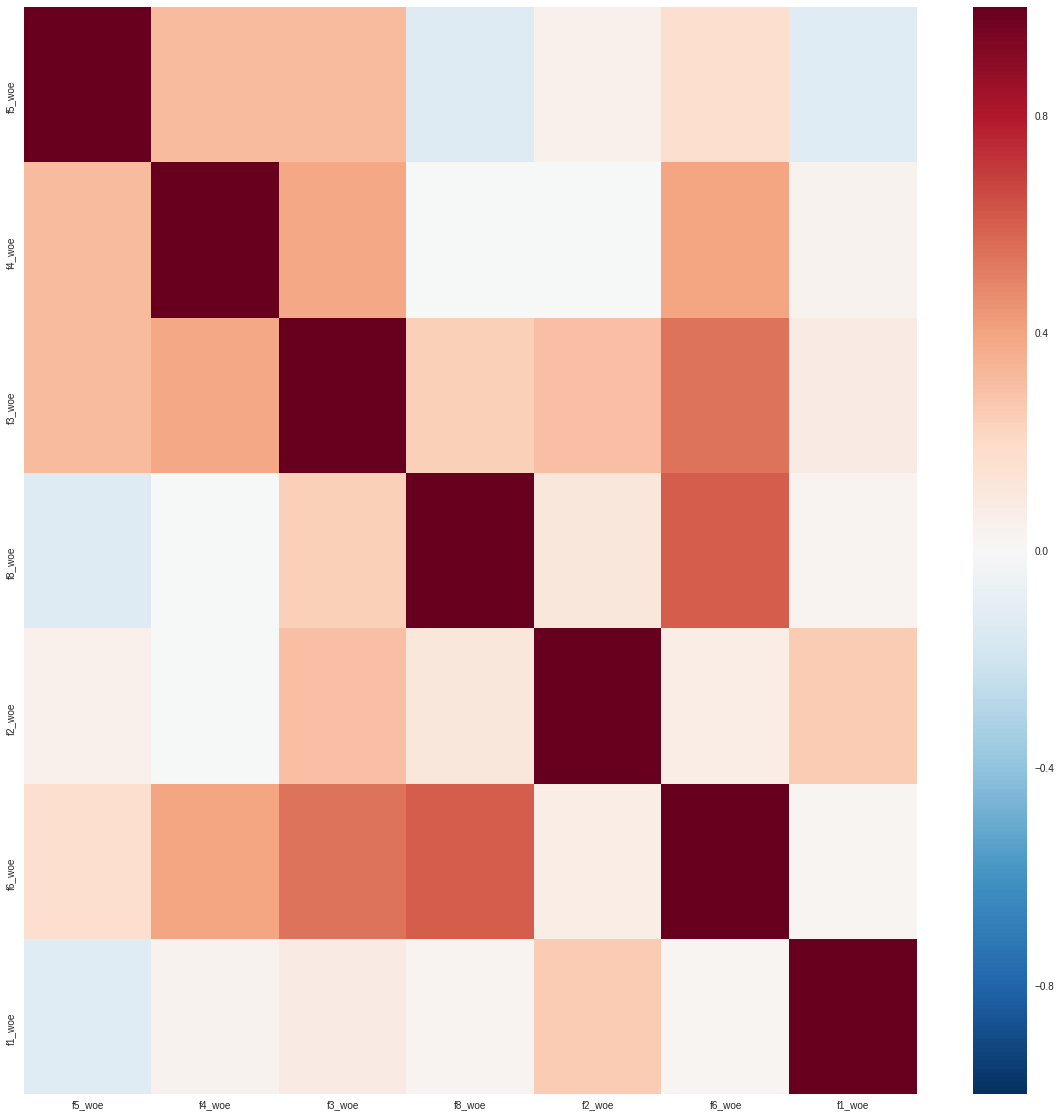

In [33]:
#final model factors' correlation
plt.figure(figsize=[20,20])
corr=correlation(binned_train[final_columns_in_model],'')  